In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits
import pysm3
import astropy.units as u

In [2]:
# for 16 pixels with different mu for each pixel and sampling from a normal distribution with mean 0
num_pixels = 16
num_samples = 1000
mu = np.random.rand(num_pixels)

In [3]:
#sample from normal distribution
samples = np.random.normal(0, mu, (num_samples, num_pixels))

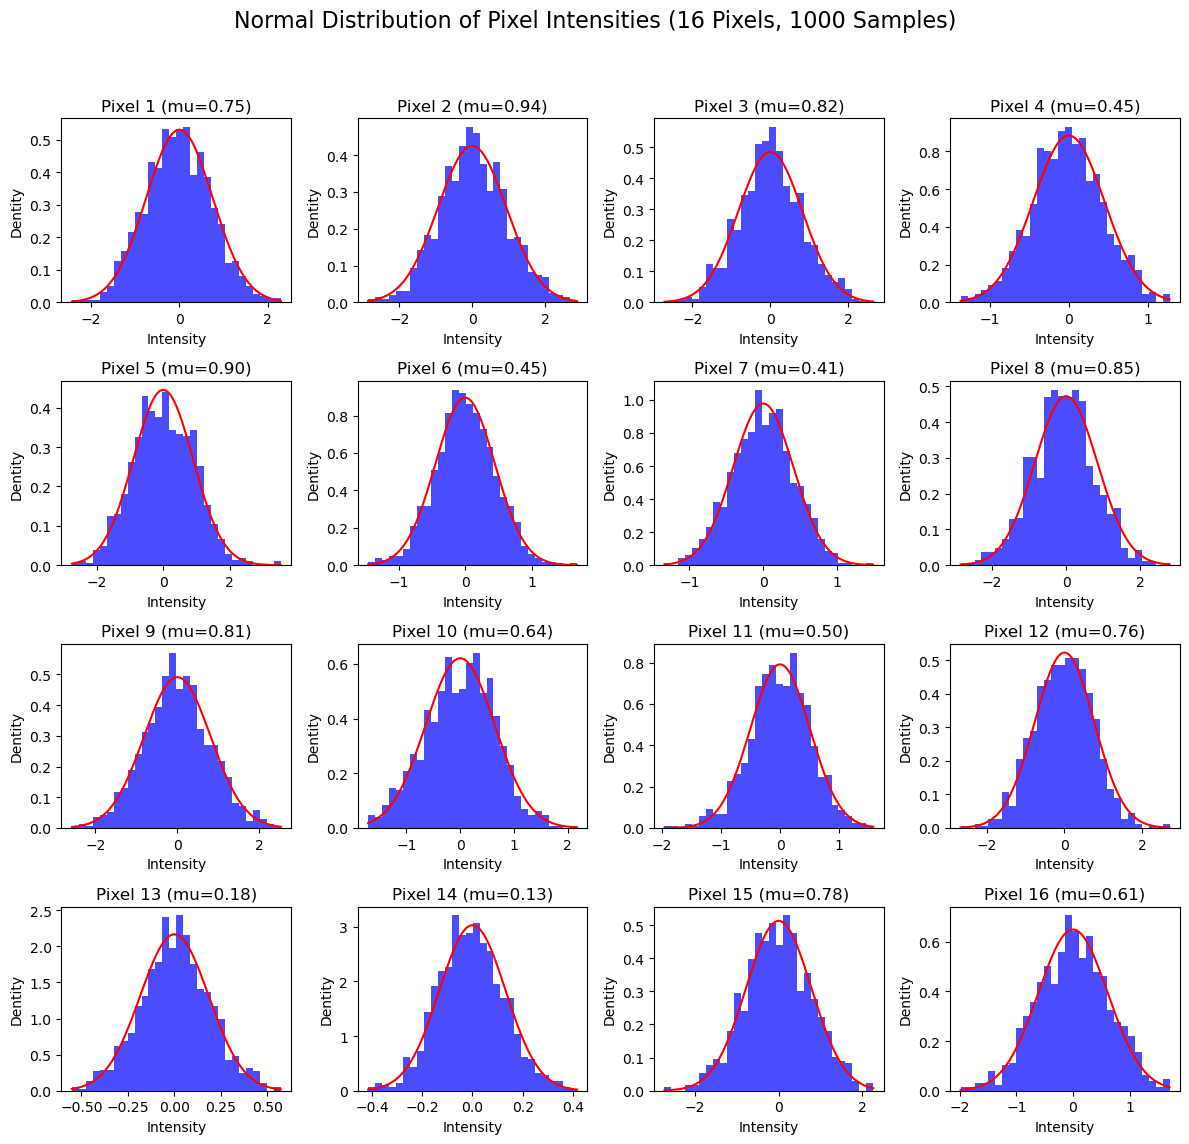

In [4]:
# Plot the distribution for each pixel
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Normal Distribution of Pixel Intensities (16 Pixels, 1000 Samples)', fontsize=16)


for i, ax in enumerate(axes.flat):
    ax.hist(samples[:, i], bins=30, density= True, color='blue', alpha=0.7)
    x_values = np.linspace(min(samples[:, i]), max(samples[:, i]), 1000)
    y_values = (1 / (mu[i] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - 0) / mu[i])**2)
    ax.plot(x_values, y_values, color='red')
    ax.set_title(f'Pixel {i+1} (mu={mu[i]:.2f})')
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Dentity')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

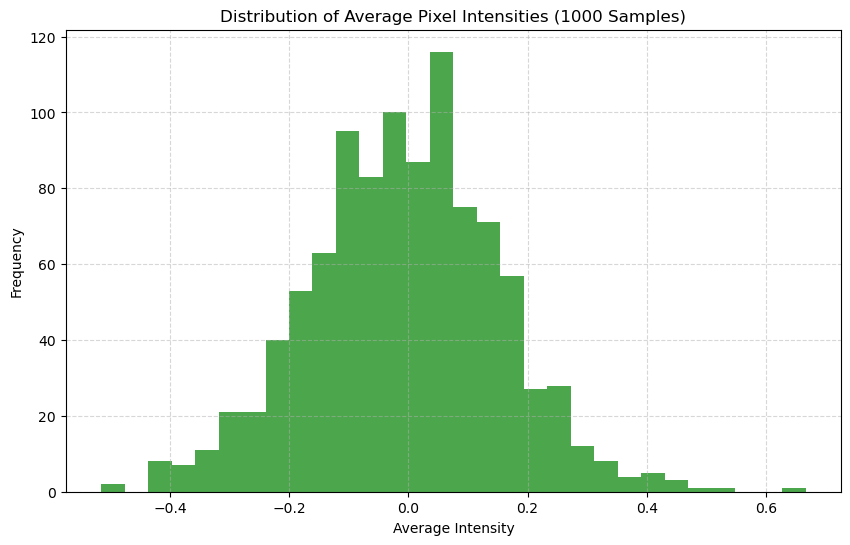

In [5]:
# Compute the average intensity across all pixels for each sample
average_pixel_intensity = samples.mean(axis=1)

# Plot the distribution of the average pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(average_pixel_intensity, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Average Pixel Intensities (1000 Samples)')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [6]:
mean_mu = mu.mean()

In [7]:
mean_samples = np.random.normal(0, mean_mu, num_samples)

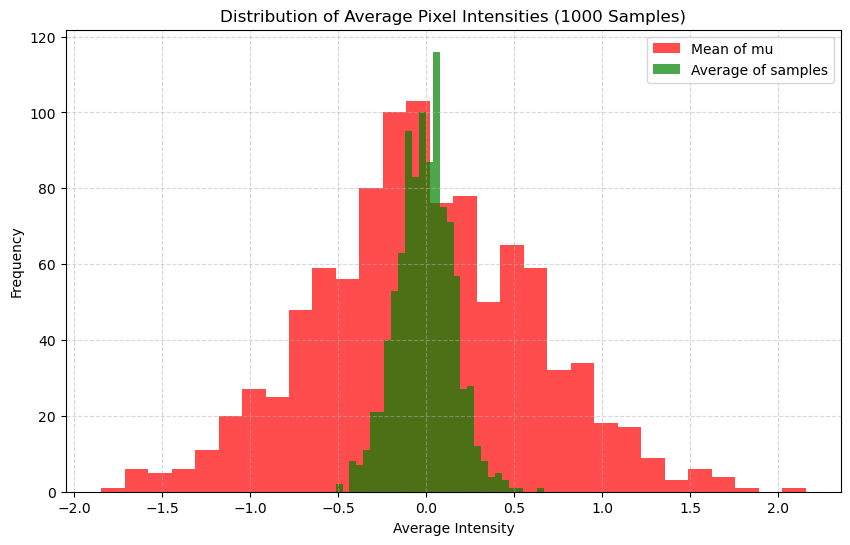

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(mean_samples, bins=30, color='red', alpha=0.7, label='Mean of mu') 
plt.hist(average_pixel_intensity, bins=30, color='green', alpha=0.7, label='Average of samples')
plt.title('Distribution of Average Pixel Intensities (1000 Samples)')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [9]:
mean_average_intensity = np.mean(average_pixel_intensity)
std_dev_average_intensity = np.std(average_pixel_intensity)

mean_average_intensity, std_dev_average_intensity

(-0.006760651796385344, 0.16000223278500875)

In [10]:
mean_mean_intensity = np.mean(mean_samples)
std_dev_mean_intensity = np.std(mean_samples)
mean_mean_intensity, std_dev_mean_intensity

(-0.014291996498526274, 0.6194204877723779)

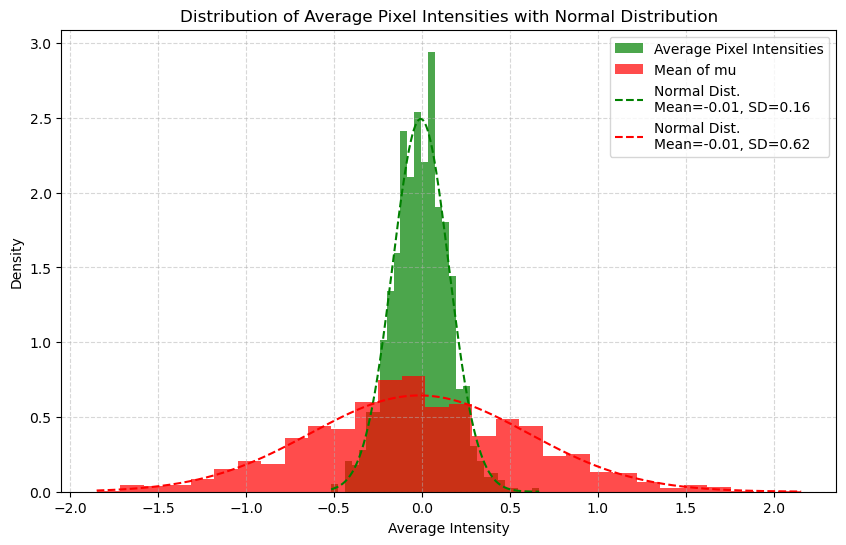

In [11]:
# Plot histogram of average pixel intensities with mean and standard deviation
plt.figure(figsize=(10, 6))
plt.hist(average_pixel_intensity, bins=30, color='green', alpha=0.7, density=True, label='Average Pixel Intensities')
plt.hist(mean_samples, bins=30, color='red', alpha=0.7, density=True, label='Mean of mu')

# Plot the normal distribution curve using the calculated mean and standard deviation
x_values = np.linspace(min(average_pixel_intensity), max(average_pixel_intensity), 1000)
x_values_mean = np.linspace(min(mean_samples), max(mean_samples), 1000)
normal_distribution = (1 / (std_dev_average_intensity * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean_average_intensity) / std_dev_average_intensity) ** 2)
mean_normal_distribution = (1 / (std_dev_mean_intensity * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values_mean - mean_mean_intensity) / std_dev_mean_intensity) ** 2)

plt.plot(x_values, normal_distribution, color='green', linestyle='--', label=f'Normal Dist.\nMean={mean_average_intensity:.2f}, SD={std_dev_average_intensity:.2f}')
plt.plot(x_values_mean, mean_normal_distribution, color='red', linestyle='--', label=f'Normal Dist.\nMean={mean_mean_intensity:.2f}, SD={std_dev_mean_intensity:.2f}')

plt.title('Distribution of Average Pixel Intensities with Normal Distribution')
plt.xlabel('Average Intensity')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


In [12]:
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
mcmc_seeds = [f'{i:02d}' for i in range(0, 100)]

In [13]:
working_dir = '/shared/data/Assets/PlanckNoise/'

def average_the_noise(frequency):
    noise_map_total = np.zeros(12*2048**2)
    for mcmc_seed in mcmc_seeds:
        fn_template = f'{working_dir}ffp10_noise_{frequency}_full_map_mc_000{mcmc_seed}.fits'
        noise_map_temp = hp.read_map(fn_template)
        noise_map_total += noise_map_temp
    return noise_map_total / len(mcmc_seeds)

In [14]:
mean_noise_map = []

In [15]:
mean_noise_map.append(average_the_noise(frequencies[8]))

In [16]:
mean_noise_map

[array([ 0.00506975, -0.00545651,  0.00503486, ...,  0.00710262,
         0.00063479,  0.00993144])]

In [17]:
mask_paht = '/home/yunan/planck_release/planck_mask.fits'
workding_dir = '/home/yunan/pyilc/output/Planck_test/'
predicton_map_path = workding_dir + 'new_prediction/CN_needletILCmap_component_CMB.fits'
noise_bias_path = workding_dir + 'new_noise_bias/CN_needletILCmap_component_CMB.fits'
average_noise_bias_path = workding_dir + 'noise_bias_average/CN_needletILCmap_component_CMB.fits'

In [18]:
mask = hp.read_map(mask_paht)
predicton_map = hp.read_map(predicton_map_path)
noise_bias = hp.read_map(noise_bias_path)
average_noise_bias = hp.read_map(average_noise_bias_path)

In [19]:
beam_fwhm = 5
beam_fwhm = beam_fwhm*np.pi / 60 / 180 
beam = hp.gauss_beam(beam_fwhm, lmax=4096)

In [20]:
def apply_mask(map, mask):
    masked_index = np.where(mask != 1)
    masked_map = map.copy()
    masked_map[masked_index] = hp.UNSEEN
    masked_map = hp.ma(masked_map)
    #masked_map.mask = mask
    return masked_map

In [21]:
predicton_map = apply_mask(predicton_map, mask)
noise_bias = apply_mask(noise_bias, mask)
average_noise_bias = apply_mask(average_noise_bias, mask)

In [22]:
def compute_power_spectrum(map1, ellmax, map2 = None, fsky = None):
    if map2 is not None:
        cl = hp.anafast(map1, map2, lmax= ellmax)
    else:
        cl = hp.anafast(map1, lmax= ellmax)
    if fsky is not None:
        cl /= fsky
    return cl

In [23]:
fsky = np.sum(mask**2)/len(mask)
nside = 2048
ellmax = 4096

In [24]:
cl_predicton = compute_power_spectrum(predicton_map, ellmax, fsky=fsky)
cl_noise_bias = compute_power_spectrum(noise_bias, ellmax, fsky=fsky)
cl_average_noise_bias = compute_power_spectrum(average_noise_bias, ellmax, fsky=fsky)

In [25]:
cl_predicton_beam = cl_predicton / beam**2
cl_noise_bias_beam = cl_noise_bias / beam**2
cl_average_noise_bias_beam = cl_average_noise_bias / beam**2

In [26]:
ells = np.arange(len(cl_predicton_beam))

In [27]:
def normalize_cl(cl):
    return cl *(ells * (ells + 1))/ (2*np.pi )

In [28]:
dl_predicton = normalize_cl(cl_predicton_beam)
dl_noise_bias = normalize_cl(cl_noise_bias_beam)
dl_average_noise_bias = normalize_cl(cl_average_noise_bias_beam)

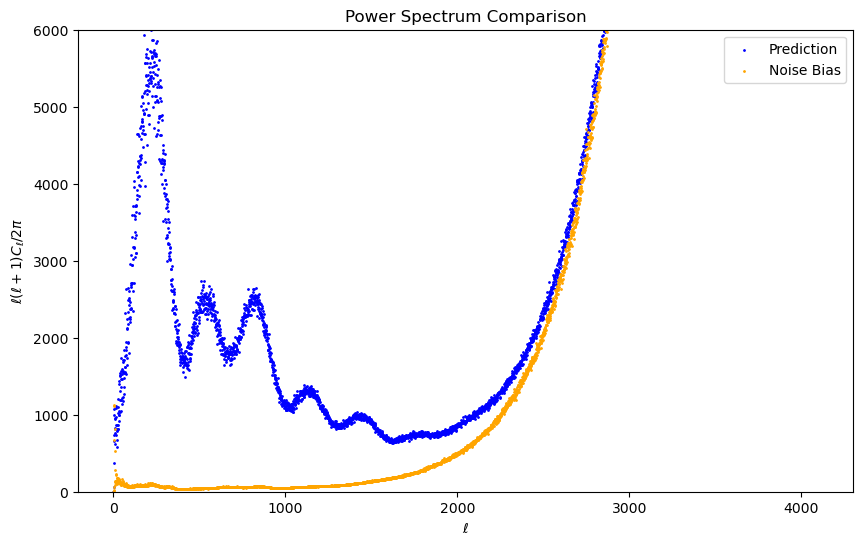

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(ells, dl_predicton, label='Prediction', color='blue', s = 1)
plt.scatter(ells, dl_noise_bias, label='Noise Bias', color='orange', s = 1)
#plt.plot(ells, dl_average_noise_bias, label='Average Noise Bias', color='green')
plt.title('Power Spectrum Comparison')
plt.ylim(0,6000)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()

In [30]:
target_cmb_path = '/home/yunan/COM_CMB_IQU-nilc_2048_R3.00_full.fits'
target_cmb = hp.read_map(target_cmb_path)
target_cmb = apply_mask(target_cmb, mask)
cl_target_cmb = compute_power_spectrum(target_cmb, ellmax, fsky=fsky)*1e12
cl_target_cmb_beam = cl_target_cmb / beam**2
dl_target_cmb = normalize_cl(cl_target_cmb_beam)

In [31]:
ell, planck_dl, delta_minus_dl, delta_plus_dl = np.genfromtxt('/home/yunan/COM_PowerSpect_CMB-TT-full_R3.01.txt', unpack=True)

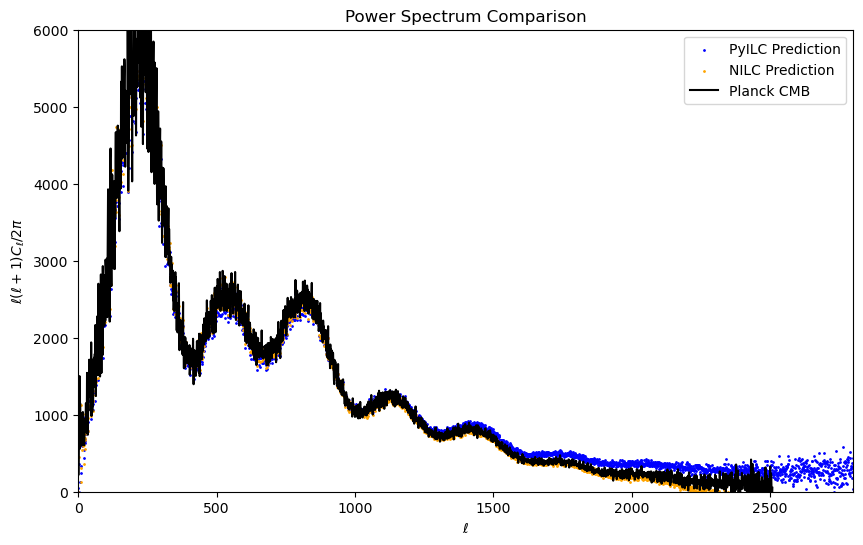

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(ells, dl_predicton - dl_noise_bias , label='PyILC Prediction', color='blue', s = 1)
plt.scatter(ells, dl_target_cmb - dl_noise_bias , label='NILC Prediction', color='orange', s = 1)
plt.plot(ell, planck_dl, label='Planck CMB', color='black')
plt.title('Power Spectrum Comparison')
plt.xlim(0,2800)
plt.ylim(0,6000)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend()
plt.show()

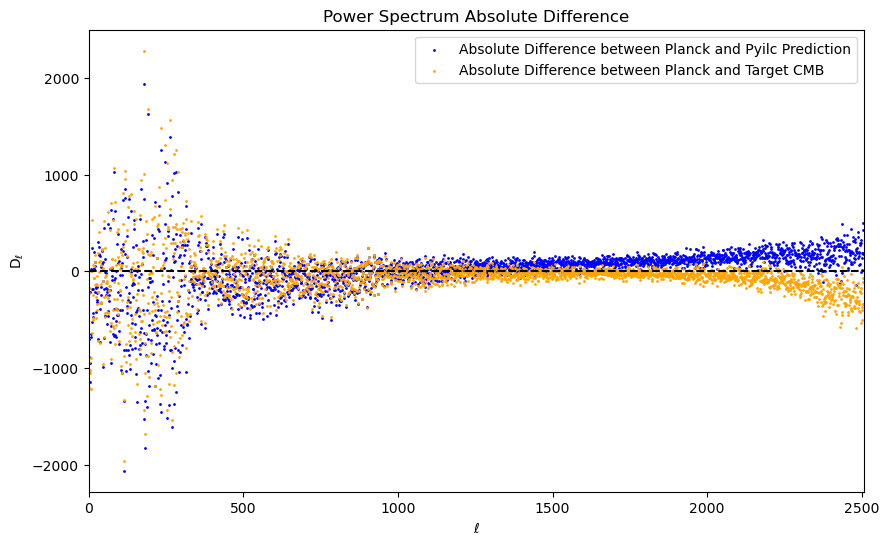

In [33]:
abs_diff = (dl_predicton[:2507] - dl_noise_bias[:2507] - planck_dl) 
abs_diif2 = (dl_target_cmb[:2507] - dl_noise_bias[:2507] - planck_dl) 
plt.figure(figsize=(10, 6))
plt.scatter(ells[:2507], abs_diff, label='Absolute Difference between Planck and Pyilc Prediction', color='blue', s = 1)
plt.scatter(ells[:2507], abs_diif2, label='Absolute Difference between Planck and Target CMB', color='orange', s = 1)
plt.title('Power Spectrum Absolute Difference')
plt.xlim(0, 2507)
#plt.ylim(-100, 100)
plt.xlabel(r'$\ell$')
plt.ylabel(r'D$_\ell$')
plt.hlines(0, 0, 2507, color='black', linestyle='--')
plt.legend()
plt.show()

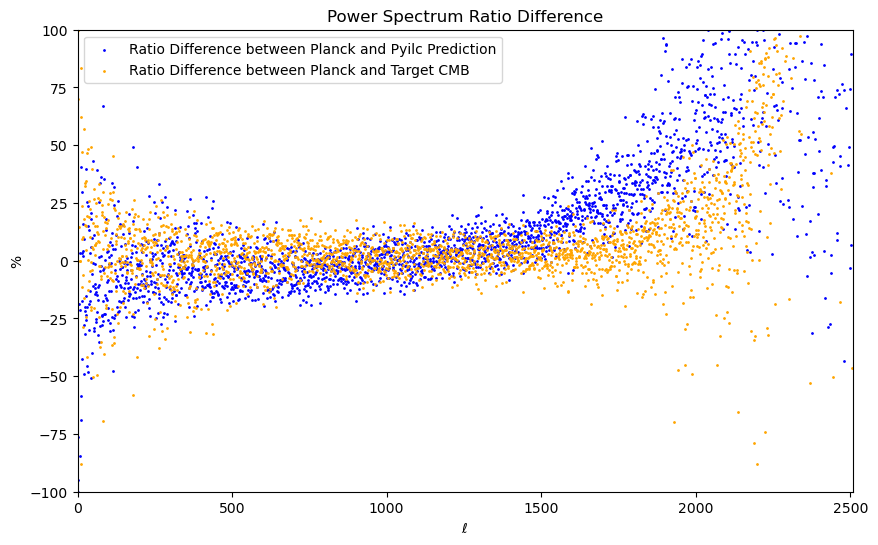

In [34]:
ratio_diff = 100*(dl_predicton[:2507] - dl_noise_bias[:2507] - planck_dl) / planck_dl
ratio_diif2 = -100*(dl_target_cmb[:2507] - dl_noise_bias[:2507] - planck_dl) / planck_dl
plt.figure(figsize=(10, 6))
plt.scatter(ells[:2507], ratio_diff, label='Ratio Difference between Planck and Pyilc Prediction', color='blue', s = 1)
plt.scatter(ells[:2507], ratio_diif2, label='Ratio Difference between Planck and Target CMB', color='orange', s = 1)
plt.title('Power Spectrum Ratio Difference')
plt.xlim(0, 2507)
plt.ylim(-100, 100)
plt.xlabel(r'$\ell$')
plt.ylabel('%')
plt.legend()
plt.show()

In [35]:
test_path = '/shared/data/Assets/Planck/'
test_file_1 = '/home/yunan/planck_release/ffp10_noise_857_full_map_mc_00000.fits' 
test_file_2 = 'HFI_SkyMap_857_2048_R3.01_full.fits'

In [36]:
test_1 = fits.open(test_file_1)
header = test_1[1].header

In [37]:
header['TUNIT1']

'MJy/sr'

In [38]:
frequecy = 857 * u.GHz

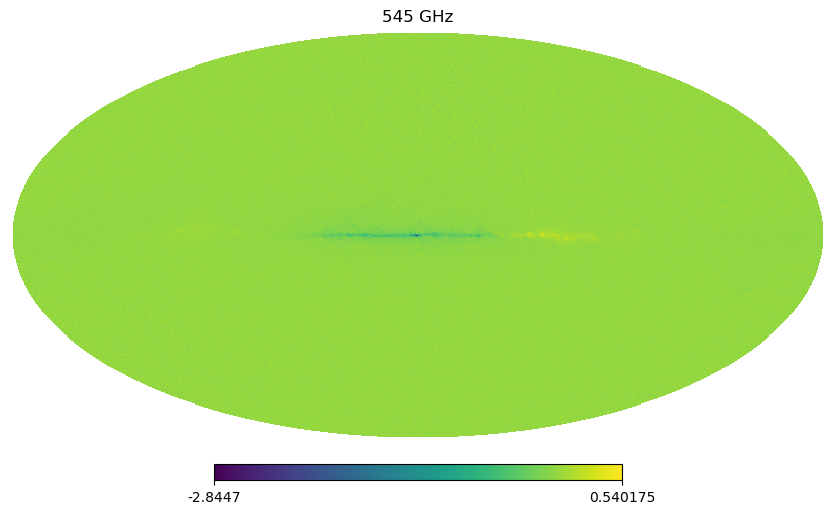

In [39]:
test_map_2 = hp.read_map( test_file_1)
hp.mollview(test_map_2, title='545 GHz')

In [40]:
test_map_2_mjy = test_map_2 * u.MJy / u.sr
test_map_2_kcmb = test_map_2_mjy.to(u.K, equivalencies=u.thermodynamic_temperature(frequecy))

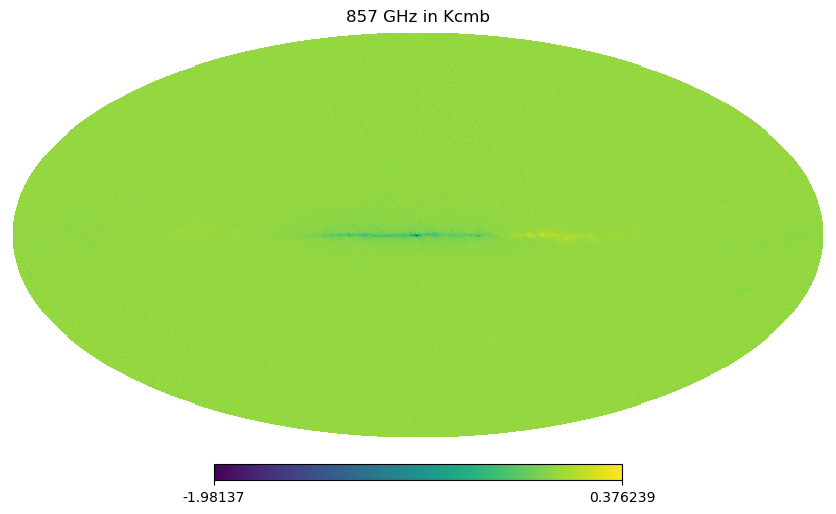

In [41]:
hp.mollview(test_map_2_kcmb.value, title='857 GHz in Kcmb')

In [42]:
hp.write_map('ffp10_noise_857_full_map_mc_00000_kcmb.fits', test_map_2_kcmb, overwrite=True)

setting the output map dtype to [dtype('float32')]


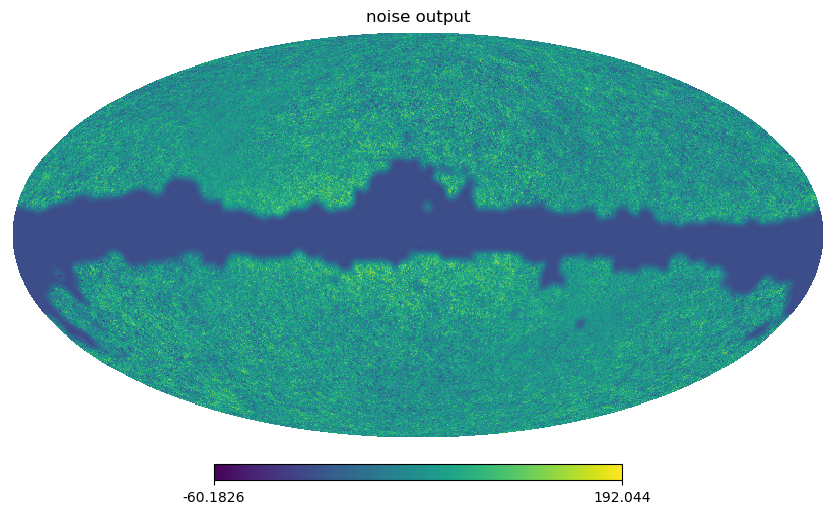

In [43]:
noise_output_path = '/home/yunan/pyilc/output/Planck_test/new_noise_bias/CN_needletILCmap_component_CMB.fits'
noise_output = hp.read_map(noise_output_path)
hp.mollview(noise_output, title='noise output')